# Covid-19 Notebook
## Applying logistic and exponential models to italian data


Infection speed = 4.881537610550319 ±0.1256841151122459
Peak infections day = 2020-03-20 04:51:49.898932 ±0.5997848309234645
Total infected = 94246.02918717194 ±6330.57942885294
End of infection ~= 2020-06-01 00:00:00


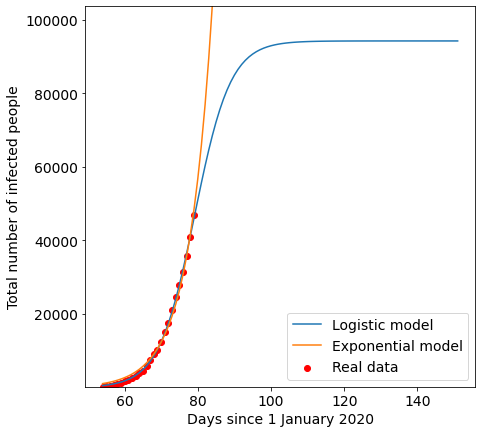

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime as dt, timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

def getData():
    url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
    df = pd.read_csv(url)
    return df


def prepareData(df):
    df = df.loc[:, ['data', 'totale_casi']]
    FMT = '%Y-%m-%d %H:%M:%S'
    date = df['data']
    df['data'] = date.map(lambda x: (dt.strptime(
        x, FMT) - dt.strptime("2020-01-01 00:00:00", FMT)).days)
    return df


def logistic_model(x, a, b, c):
    return c/(1+np.exp(-(x-b)/a))


def exponential_model(x, a, b, c):
    return a*np.exp(b*(x-c))


def fitModel(df, model, p0):
    x = list(df.iloc[:, 0])
    y = list(df.iloc[:, 1])
    fit = curve_fit(model, x, y, p0=p0, maxfev=1000)
    return fit


def infectionEnd(a, b, c):
    sol = int(fsolve(lambda x: logistic_model(x, a, b, c) - int(c), b))
    return sol, dt.strptime("2020-01-01", '%Y-%m-%d') + datetime.timedelta(days=sol)


def fitErrors(fit):
    return [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]


def printResults(fit, errors, end):
    peakday = dt.strptime("2020-01-01", '%Y-%m-%d') + \
        datetime.timedelta(days=fit[1])
    print(
        f"Infection speed = {fit[0]} ±{errors[0]}\nPeak infections day = {peakday} ±{errors[1]}\nTotal infected = {fit[2]} ±{errors[2]}")
    print(f"End of infection ~= {end}")


def plot(x, y, c, fit, exp_fit, sol):
    pred_x = list(range(max(x), sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x, y, label="Real data", color="red")
    # Predicted logistic curve
    plt.plot(x+pred_x, [logistic_model(i, fit[0][0], fit[0][1], fit[0][2])
                        for i in x+pred_x], label="Logistic model")
    # Predicted exponential curve
    plt.plot(x+pred_x, [exponential_model(i, exp_fit[0][0], exp_fit[0]
                                          [1], exp_fit[0][2]) for i in x+pred_x], label="Exponential model")
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9, c*1.1))
    plt.show()
    
df = getData()
df = prepareData(df)
fit = fitModel(df, logistic_model, [2, 100, 20000])
exp_fit = fitModel(df, exponential_model, [1, 1, 1])
errors = fitErrors(fit)
sol, end = infectionEnd(fit[0][0], fit[0][1], fit[0][2])
printResults(fit[0], errors, end)
plot(list(df.iloc[:, 0]), list(df.iloc[:, 1]),
     fit[0][2], fit, exp_fit, sol)
